In [ ]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, OneCycleLR
from torchvision import transforms
import torch.nn.functional as F


In [ ]:
!pip install git+https://github.com/smitasasindran/eva5utils.git

  Cloning https://github.com/smitasasindran/eva5utils.git to /tmp/pip-req-build-0vhzqhfz
  Running command git clone -q https://github.com/smitasasindran/eva5utils.git /tmp/pip-req-build-0vhzqhfz
     |████████████████████████████████| 634kB 5.3MB/s 
  Created wheel for eva5utils: filename=eva5utils-0.1.0-cp36-none-any.whl size=29646 sha256=eae6e2e12b46266331269571f7aaa38f3e3e4378f4aeef85680b10f64e178d13
  Stored in directory: /tmp/pip-ephem-wheel-cache-q2a92e4w/wheels/c6/bb/ac/e3952b213bfdb25cb23715782e1a6b4b4b5cb10e42a2b80aa9
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=85df5e6e18f1e0c07bc5e601e1ad519a3f87f110bc7b6ec826cf1707b6a65ddb
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built eva5utils imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
from eva5utils.dataloaders import load_cifar10
from eva5utils.model import ResNet18, Model11
from eva5utils.transforms import model9_resnet_train_transforms, model9_resnet_test_transforms, model11_davidnet_train_transforms
from eva5utils.train import train_loop, train_onecyclelr
from eva5utils.test import test_loop
from eva5utils.utils import plot_samples, LRFinder, TrainDataLoaderIter, ValDataLoaderIter, plot_misclassified_gradcam, plot_train_vs_test, LRRangeFinder
from eva5utils.utils.helpers import show_model_summary, DEVICE, IS_CUDA, accuracy_per_class, show_gradcam, find_misclassified

In [ ]:
# Constants, put in config
epochs = 24
cuda_batch_size=512
cpu_batch_size = 4
num_workers = 4


model = Model11()
show_model_summary(model.to(DEVICE), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [ ]:
# Load datasets
(trainloader, testloader, classes) = load_cifar10(model11_davidnet_train_transforms(), model9_resnet_test_transforms(), cuda_batch_size, cpu_batch_size, num_workers)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(DEVICE)
torch.cuda.is_available()

cuda


True

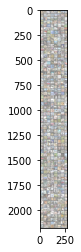

In [ ]:
plot_samples(trainloader)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: Maximum Accuracy
Suggested LR: 2.43E+00


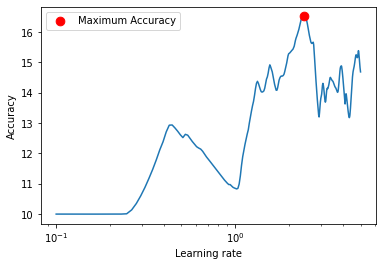

In [ ]:
model = Model11().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

lr_finder = LRRangeFinder(model, optimizer, criterion, device=DEVICE)
lr_finder.range_test(trainloader, testloader, end_lr=5, num_iter=300, step_mode="linear")
lr_finder.plot() # to inspect the accuracy-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.11E-01


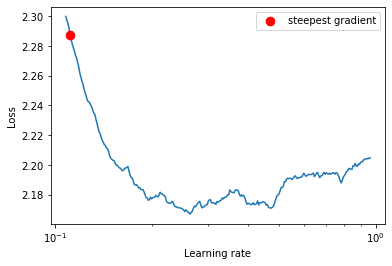

In [ ]:
model = Model11().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9) #lr=1e-7

lr_finder = LRFinder(model, optimizer, criterion, device=DEVICE)
lr_finder.range_test(trainloader, end_lr=1, num_iter=300)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
# Training loop
model = Model11().to(DEVICE)
criterion = nn.CrossEntropyLoss()

lr = 1.11E-01 # Max lr from range test
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)   #1.03E-01      #3.85E-02, 2.18E-02

#scheduler = OneCycleLR(optimizer, max_lr=lr, epochs=24, steps_per_epoch=98, pct_start=0.208, anneal_strategy='linear', div_factor=10.0, final_div_factor=1.0)
scheduler = OneCycleLR(optimizer, max_lr=lr, epochs=24, steps_per_epoch=98, pct_start=0.208, anneal_strategy='linear', div_factor=10.0)

#train_loss, train_acc = train_loop(epochs, trainloader, model, DEVICE, optimizer, criterion, scheduler, True)
train_loss, train_acc = train_onecyclelr(epochs, trainloader, model, DEVICE, optimizer, criterion, scheduler)

Minibatch: epoch= 0 , batch= 0 , loss= 2.315810203552246 , corrects= 41 , lr= 0.011304622544119817
Minibatch: epoch= 0 , batch= 20 , loss= 47.34205913543701 , corrects= 1986 , lr= 0.015397073426516132
Minibatch: epoch= 0 , batch= 40 , loss= 90.31549620628357 , corrects= 5144 , lr= 0.01948952430891245
Minibatch: epoch= 0 , batch= 60 , loss= 132.63040399551392 , corrects= 8621 , lr= 0.023581975191308766
Minibatch: epoch= 0 , batch= 80 , loss= 174.24975037574768 , corrects= 12464 , lr= 0.027674426073705086
[1,    98] loss: 209.507
lr is:  0.031153009323741952
Minibatch: epoch= 1 , batch= 0 , loss= 2.0709736347198486 , corrects= 198 , lr= 0.03135763186786177
Minibatch: epoch= 1 , batch= 20 , loss= 43.13571643829346 , corrects= 4330 , lr= 0.035450082750258086
Minibatch: epoch= 1 , batch= 40 , loss= 83.9924829006195 , corrects= 8555 , lr= 0.0395425336326544
Minibatch: epoch= 1 , batch= 60 , loss= 124.64026880264282 , corrects= 12899 , lr= 0.04363498451505072
Minibatch: epoch= 1 , batch= 80 ,

In [ ]:
# Test Loop

test_loss, test_acc = test_loop(testloader, model, DEVICE, criterion)
accuracy_per_class(model, classes, testloader, DEVICE)

Accuracy of the network on the 10000 test images: 80 %, Test loss: 348.1222438812256
Accuracy of plane : 100 %
Accuracy of   car : 93 %
Accuracy of  bird :  0 %
Accuracy of   cat : 66 %
Accuracy of  deer : 100 %
Accuracy of   dog : 90 %
Accuracy of  frog : 100 %
Accuracy of horse : 83 %
Accuracy of  ship : 87 %
Accuracy of truck : 87 %
